In [1]:
import pandas as pd
import numpy as np
import openpyxl 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path



In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) / 'data' /'processed'
external_dir = Path(TOP) / 'data' /'external'
figures_dir = Path(TOP) / 'reports' /'figures'

In [3]:
import genra_nta

In [4]:
from genra_nta.chm.chem import FingerprintGenerator

In [5]:
from sklearn.model_selection import train_test_split

In [8]:
source = pd.read_csv(external_dir/'toxval_wmetab.csv', index_col = [0])

In [18]:
y = source.set_index('dtxsid')['pPOD']

In [11]:
fp_gen_s = FingerprintGenerator()

In [12]:
fp_gen_s.add_chemicals_from_dataframe(source)
source_FP = fp_gen_s.generate_fingerprints()

[14:11:25] WARNING: not removing hydrogen atom without neighbors
[14:11:25] WARNING: not removing hydrogen atom without neighbors
[14:11:25] WARNING: not removing hydrogen atom without neighbors
[14:11:25] WARNING: not removing hydrogen atom without neighbors
[14:11:25] WARNING: not removing hydrogen atom without neighbors
[14:11:25] WARNING: not removing hydrogen atom without neighbors
[14:11:25] WARNING: not removing hydrogen atom without neighbors


In [21]:
X_train, X_test, y_train, y_test = train_test_split(source_FP, y, test_size=0.25,  random_state=42)

In [23]:
from genra_nta.nn.nn import NearestNeighborAnalyzer

In [24]:
analyzer = NearestNeighborAnalyzer(n_neighbors=10, metric='jaccard')

In [25]:
analyzer.train_model(X_train)

In [26]:
mylst = []
for idx in X_train.index.tolist():
    a = analyzer.find_analogues(target_chemical_id = idx, target_df=X_train)
    mylst.append(a)

/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/Documents/python/nts_rax/genra_nta/nn/nn.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: self.fingerprints.index[idx])
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/Documents/python/nts_rax/genra_nta/nn/nn.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: self.fingerprints.index[idx])
/home/grace/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: Data

In [27]:
mylst[0]

,analogue,jaccard,target
0,DTXSID90883480,1.000000,DTXSID5020077
1,DTXSID5020077,1.000000,DTXSID5020077
2,DTXSID3027297,0.695652,DTXSID5020077
3,DTXSID9021683,0.695652,DTXSID5020077
4,DTXSID6021664,0.533333,DTXSID5020077
5,DTXSID3021641,0.533333,DTXSID5020077
6,DTXSID3026930,0.533333,DTXSID5020077
7,DTXSID8021642,0.533333,DTXSID5020077
8,DTXSID2021602,0.533333,DTXSID5020077
9,DTXSID3021645,0.500000,DTXSID5020077


In [34]:
y_train1 = y_train.reset_index()

In [29]:
from genra_nta.rax.reg.reg import ToxicityPredictor

In [35]:
genra_dict = {}
genra_dict2 = {}
errors = []
for i, df in enumerate(mylst):
    try:
        k = mylst[i]['target'].unique()[0]
        predictor = ToxicityPredictor(analogue_df=df, tox_data=y_train1, similarity_col='jaccard', activity_col='pPOD')
        a =predictor.join_data()
        weighted_avg = predictor.wtavg()
        
    except Exception as e:
        errors.append([i,e])
    genra_dict[k] = weighted_avg
    genra_dict2[k] = a.jaccard.tolist(), a.pPOD.tolist()

In [39]:
#y_train1

In [40]:
train_toxval = (pd.merge(y_train1, pd.DataFrame(list(genra_dict.items()), columns = ['target_dtxsid', 'pred_pPOD']), left_on = 'dtxsid', right_on = 'target_dtxsid')
 .drop(['dtxsid'], axis = 1)
 .assign(residual = lambda x: x['pPOD']-x['pred_pPOD'])
)

In [43]:
from sklearn.metrics import r2_score,root_mean_squared_error

In [42]:
r2_score(train_toxval['pPOD'], train_toxval['pred_pPOD'])

0.2680243582709718

In [44]:
root_mean_squared_error(train_toxval['pPOD'], train_toxval['pred_pPOD'])

0.9092391090398664

In [45]:
import seaborn as sns


<Axes: xlabel='pPOD', ylabel='pred_pPOD'>

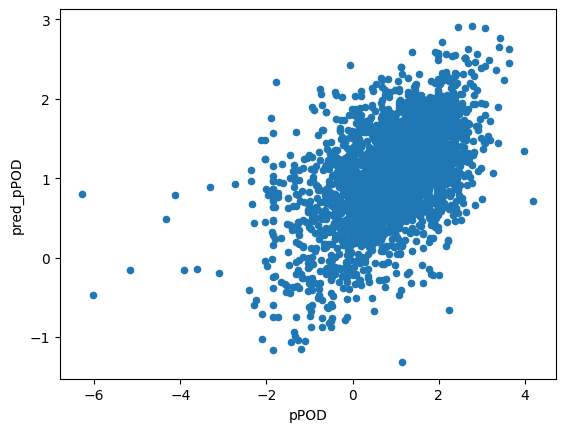

In [48]:
train_toxval.plot(kind = 'scatter', x = 'pPOD', y = 'pred_pPOD')

<Axes: ylabel='Frequency'>

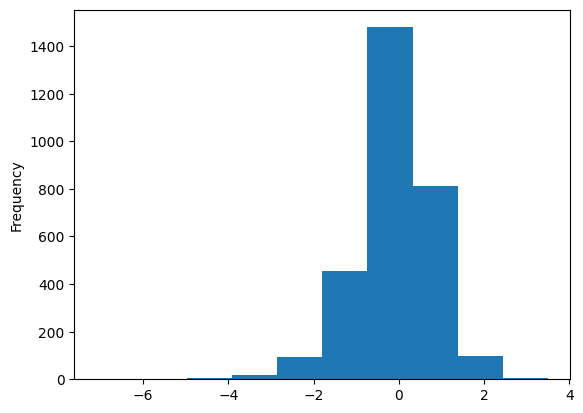

In [51]:
train_toxval['residual'].plot(kind = 'hist')

## Re-try with Embeddings

In [52]:
txval_embeddings_df = pd.read_csv(external_dir/'txval_acutegcn_embeddings.csv')

In [58]:
txval_embeddings_df = txval_embeddings_df.set_index('dtxsid')

In [94]:
def masked_cosine_similarity(vec1, vec2):
    """Compute cosine similarity only over shared nonzero dimensions."""
    mask = (vec1 != 0) & (vec2 != 0)
    if not np.any(mask):  # No common nonzero elements
        return 0.0  

    vec1_masked, vec2_masked = vec1[mask], vec2[mask]
    dot_product = np.dot(vec1_masked, vec2_masked)
    norm1 = np.linalg.norm(vec1_masked)
    norm2 = np.linalg.norm(vec2_masked)

    return dot_product / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

In [95]:
def masked_cosine_similarity_matrix(X):
    """Compute pairwise masked cosine similarity matrix for sparse embeddings."""
    n_samples = X.shape[0]
    similarity_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(i, n_samples):  # Compute only upper triangle (symmetric)
            sim = masked_cosine_similarity(X[i], X[j])
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim  # Symmetric matrix
    
    return similarity_matrix

In [116]:
cosine_emb = masked_cosine_similarity_matrix(txval_embeddings_df.values)

In [117]:
cosine_emb = pd.DataFrame(cosine_emb, index = txval_embeddings_df.index, columns = txval_embeddings_df.index)

In [118]:
cosine_emb.index.name = None
cosine_emb.columns.name = None
cosine_emb

,DTXSID001004378,DTXSID001005033,DTXSID001009930,DTXSID001016113,DTXSID001019355,DTXSID001019793,DTXSID001019836,DTXSID001020128,DTXSID001020930,DTXSID001021219,...,DTXSID90909356,DTXSID90925652,DTXSID90961393,DTXSID90961439,DTXSID90968685,DTXSID90968887,DTXSID90976780,DTXSID90978461,DTXSID90990466,DTXSID90998205
DTXSID001004378,1.000000,0.995549,0.985510,0.866719,0.989251,0.988576,0.894153,0.943864,0.940176,0.757995,...,0.963326,0.773722,0.970800,0.963139,0.837294,0.873051,0.744321,0.964444,0.845834,0.918785
DTXSID001005033,0.995549,1.000000,0.976415,0.900714,0.991246,0.993468,0.922703,0.965925,0.960428,0.807194,...,0.981447,0.821620,0.985066,0.979759,0.878018,0.902039,0.794644,0.981064,0.884701,0.944272
DTXSID001009930,0.985510,0.976415,1.000000,0.865013,0.981710,0.972955,0.895338,0.924781,0.936817,0.746443,...,0.945522,0.762200,0.960458,0.951324,0.824299,0.887722,0.739645,0.948545,0.834407,0.915069
DTXSID001016113,0.866719,0.900714,0.865013,1.000000,0.916220,0.920746,0.982005,0.970894,0.978812,0.973231,...,0.960442,0.978131,0.942881,0.958214,0.994253,0.987899,0.971483,0.959670,0.993326,0.986412
DTXSID001019355,0.989251,0.991246,0.981710,0.916220,1.000000,0.997937,0.929432,0.971925,0.970553,0.822172,...,0.980076,0.834778,0.978208,0.980902,0.891465,0.912781,0.806201,0.985112,0.899075,0.953406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID90968887,0.873051,0.902039,0.887722,0.987899,0.912781,0.911632,0.989498,0.958101,0.977897,0.953382,...,0.956734,0.960155,0.953118,0.959059,0.973183,1.000000,0.960317,0.952280,0.974932,0.985346
DTXSID90976780,0.744321,0.794644,0.739645,0.971483,0.806201,0.812390,0.955496,0.911863,0.921544,0.996231,...,0.892709,0.996426,0.871457,0.890590,0.982932,0.960317,1.000000,0.886834,0.980487,0.943732
DTXSID90978461,0.964444,0.981064,0.948545,0.959670,0.985112,0.986172,0.972794,0.997466,0.993999,0.900949,...,0.998712,0.910710,0.991894,0.998306,0.948996,0.952280,0.886834,1.000000,0.955222,0.987265
DTXSID90990466,0.845834,0.884701,0.834407,0.993326,0.899075,0.903492,0.982481,0.971807,0.973319,0.988147,...,0.955574,0.991135,0.934508,0.953796,0.999109,0.974932,0.980487,0.955222,1.000000,0.984053


In [119]:
D_emb = 1-(cosine_emb +1)/2

In [120]:
D_emb

,DTXSID001004378,DTXSID001005033,DTXSID001009930,DTXSID001016113,DTXSID001019355,DTXSID001019793,DTXSID001019836,DTXSID001020128,DTXSID001020930,DTXSID001021219,...,DTXSID90909356,DTXSID90925652,DTXSID90961393,DTXSID90961439,DTXSID90968685,DTXSID90968887,DTXSID90976780,DTXSID90978461,DTXSID90990466,DTXSID90998205
DTXSID001004378,0.000000,0.002225,0.007245,0.066640,0.005375,0.005712,0.052924,0.028068,0.029912,0.121002,...,0.018337,0.113139,0.014600,0.018430,0.081353,0.063474,0.127839,0.017778,7.708322e-02,0.040608
DTXSID001005033,0.002225,0.000000,0.011793,0.049643,0.004377,0.003266,0.038648,0.017037,0.019786,0.096403,...,0.009276,0.089190,0.007467,0.010121,0.060991,0.048980,0.102678,0.009468,5.764947e-02,0.027864
DTXSID001009930,0.007245,0.011793,0.000000,0.067493,0.009145,0.013523,0.052331,0.037609,0.031591,0.126778,...,0.027239,0.118900,0.019771,0.024338,0.087850,0.056139,0.130178,0.025727,8.279660e-02,0.042465
DTXSID001016113,0.066640,0.049643,0.067493,0.000000,0.041890,0.039627,0.008998,0.014553,0.010594,0.013385,...,0.019779,0.010934,0.028560,0.020893,0.002874,0.006051,0.014259,0.020165,3.336783e-03,0.006794
DTXSID001019355,0.005375,0.004377,0.009145,0.041890,0.000000,0.001032,0.035284,0.014038,0.014724,0.088914,...,0.009962,0.082611,0.010896,0.009549,0.054267,0.043610,0.096899,0.007444,5.046258e-02,0.023297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID90968887,0.063474,0.048980,0.056139,0.006051,0.043610,0.044184,0.005251,0.020950,0.011051,0.023309,...,0.021633,0.019922,0.023441,0.020470,0.013408,0.000000,0.019841,0.023860,1.253425e-02,0.007327
DTXSID90976780,0.127839,0.102678,0.130178,0.014259,0.096899,0.093805,0.022252,0.044068,0.039228,0.001885,...,0.053645,0.001787,0.064271,0.054705,0.008534,0.019841,0.000000,0.056583,9.756747e-03,0.028134
DTXSID90978461,0.017778,0.009468,0.025727,0.020165,0.007444,0.006914,0.013603,0.001267,0.003000,0.049525,...,0.000644,0.044645,0.004053,0.000847,0.025502,0.023860,0.056583,0.000000,2.238905e-02,0.006368
DTXSID90990466,0.077083,0.057649,0.082797,0.003337,0.050463,0.048254,0.008759,0.014096,0.013340,0.005927,...,0.022213,0.004432,0.032746,0.023102,0.000445,0.012534,0.009757,0.022389,1.110223e-16,0.007974


In [106]:
train_ids = X_train.index.tolist()

In [107]:
len(train_ids)

2968

In [121]:
D_emb1 = D_emb.loc[train_ids, train_ids]

In [125]:
from genra_nta.nn.nn import NearestNeighborAnalyzer

In [134]:
analyzer_emb = NearestNeighborAnalyzer(n_neighbors=10, metric='precomputed')
analyzer_emb.train_model(D_emb1)



In [146]:
nn = NearestNeighbors(metric="precomputed", n_neighbors=10)  # Adjust neighbors as needed
nbrs = nn.fit(D_emb1)





In [147]:
def make_analogue(m, FP, target_df, dtx):
    dist, indices = m.kneighbors(target_df.loc[[dtx]])
    neighbour_indices_df = pd.DataFrame(indices)
    sims = 1 - dist
    neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
    analogue_df = pd.concat([neighbour_labels_df.T, pd.DataFrame(sims).T], axis = 1)
    analogue_df['target'] = dtx
    analogue_df.columns = ['analogue', 'jaccard', 'target']
    return analogue_df

In [148]:
mylst_emb = []
for idx in X_train.index.tolist():
    a = make_analogue(m = nbrs, FP = D_emb1, target_df = D_emb1, dtx = idx)
    mylst_emb.append(a)

/tmp/ipykernel_347705/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_347705/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_347705/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_347705/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_347705/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.in

In [149]:
mylst[0]

,analogue,jaccard,target
0,DTXSID90883480,1.000000,DTXSID5020077
1,DTXSID5020077,1.000000,DTXSID5020077
2,DTXSID3027297,0.695652,DTXSID5020077
3,DTXSID9021683,0.695652,DTXSID5020077
4,DTXSID6021664,0.533333,DTXSID5020077
5,DTXSID3021641,0.533333,DTXSID5020077
6,DTXSID3026930,0.533333,DTXSID5020077
7,DTXSID8021642,0.533333,DTXSID5020077
8,DTXSID2021602,0.533333,DTXSID5020077
9,DTXSID3021645,0.500000,DTXSID5020077


In [150]:
mylst_emb[1]

,analogue,jaccard,target
0,DTXSID7023194,1.000000,DTXSID7023194
1,DTXSID3027164,0.999982,DTXSID7023194
2,DTXSID30208552,0.999921,DTXSID7023194
3,DTXSID3029655,0.999858,DTXSID7023194
4,DTXSID6020480,0.999808,DTXSID7023194
5,DTXSID2023193,0.999711,DTXSID7023194
6,DTXSID6024206,0.999702,DTXSID7023194
7,DTXSID8027614,0.999684,DTXSID7023194
8,DTXSID5020281,0.999675,DTXSID7023194
9,DTXSID2026529,0.999643,DTXSID7023194


In [151]:
genra_dict2 = {}

errors = []
for i, df in enumerate(mylst_emb):
    try:
        k = mylst_emb[i]['target'].unique()[0]
        predictor = ToxicityPredictor(analogue_df=df, tox_data=y_train1, similarity_col='jaccard', activity_col='pPOD')
        a =predictor.join_data()
        weighted_avg = predictor.wtavg()
        
    except Exception as e:
        errors.append([i,e])
    genra_dict2[k] = weighted_avg
    

In [152]:
embed_toxval = (pd.merge(y_train1, pd.DataFrame(list(genra_dict2.items()), columns = ['target_dtxsid', 'pred_pPOD']), left_on = 'dtxsid', right_on = 'target_dtxsid')
 .drop(['dtxsid'], axis = 1)
 .assign(residual = lambda x: x['pPOD']-x['pred_pPOD'])
)

In [153]:
embed_toxval
r2_score(embed_toxval['pPOD'], embed_toxval['pred_pPOD'])

-0.07822376470301085

In [154]:
root_mean_squared_error(embed_toxval['pPOD'], embed_toxval['pred_pPOD'])

1.1035302512452274

<Axes: xlabel='pPOD', ylabel='pred_pPOD'>

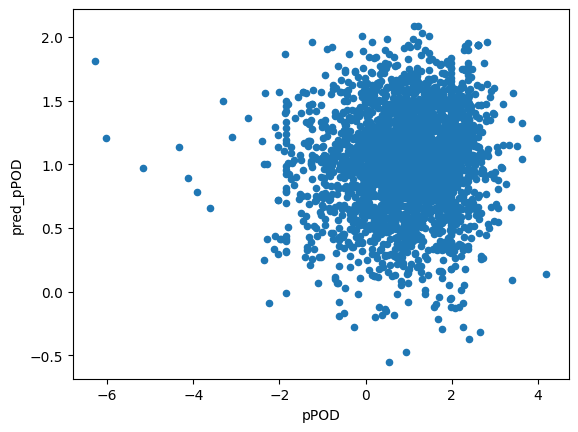

In [157]:
embed_toxval.plot(kind = 'scatter', x = 'pPOD', y = 'pred_pPOD')


<Axes: ylabel='Frequency'>

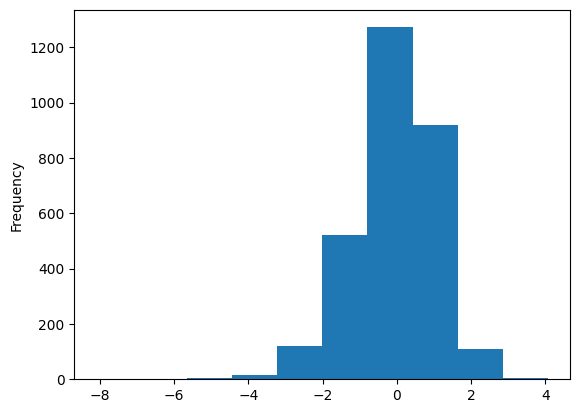

In [156]:
embed_toxval['residual'].plot(kind = 'hist')